# Land-Cover Classification in Waltham Forest (2020 – 2024)  
## Notebook 03 – Supervised Random Forest

This notebook uses manually labelled sample points to train a **Random Forest**
land-cover classifier, applies it to Sentinel-2 composites (2020-2024), and
compares the results with the unsupervised K-means maps generated in
Notebook 02.


# 1. Setup

In [1]:
# Optional: Environmental Cost Tracking
import time
start_time = time.time()

In [2]:
# Mount Google Drive (comment out if running locally)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# One-time package installs
!pip install -q geopandas shapely geemap==0.17.3 folium rtree eeconvert
!pip -q install geopandas rasterio joblib scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85

In [4]:
# Import Core Libraries
import time, json, numpy as np, pandas as pd, geopandas as gpd
import rasterio, joblib, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pathlib import Path

In [5]:
# Define Direcories
ROOT   = Path('/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/')
RAW   = ROOT/'raw'                       # Sentinel-2 TIFFs
MAPS  = ROOT/'maps'/'rf'; MAPS.mkdir(parents=True, exist_ok=True)
FIG   = ROOT/'figures';         FIG.mkdir(exist_ok=True)

## 1.1 AOI Preparation
Prepare the area of interest (AOI) for Earth Engine sampling. Convert a GeoJSON to shapefile and use Earth Engine to stratify-sample the ESA WorldCover 2021 map.

In [6]:
import geopandas as gpd
from pathlib import Path

# Load GeoJSON AOI
gdf = gpd.read_file("/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/raw/waltham_forest.geojson")

# Save as shapefile for Earth Engine
out_path = Path("/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/data/waltham_shapefile/waltham_forest.shp")
out_path.parent.mkdir(parents=True, exist_ok=True)
gdf.to_file(out_path, driver="ESRI Shapefile")


**Google Earth Engine Stratified Sampling**
- Upload the shapefile to GEE and run the following script to sample 250 points per class from ESA WorldCover 2021.  
- The classes are re-mapped into 4 super-classes: water, vegetation, bare, urban.
- Export the result as a GeoJSON and load it here for Random-Forest training.

```
// AOI = Waltham Forest boundary uploaded as ee.FeatureCollection("users/you/wf")
var wf   = ee.FeatureCollection("projects/greenbelt-project/assets/wf");

// Reference layer: ESA WorldCover 2021 (10 m, 11 classes)
var wc   = ee.Image("ESA/WorldCover/v200/2021");

// Map to your four super-classes
var reclass = wc.remap(
      [10,20,30,40,50,60,70,80,90,95],
      [3, 1, 1, 1, 1, 3, 2, 0, 0, 0]);   // 0 water, 1 vegetation, 2 bare, 3 urban

// Stratified sample: 250 points per class
var pts = reclass.stratifiedSample({
            numPoints: 250,
            classBand: 'remapped',
            region: wf,
            scale: 10,
            geometries: true,
            seed: 42});

// Re-encode to strings for the RF script
pts = pts.map(function(f){
    var lbl = f.get('remapped');
    return f.set('class', ee.String(
        ee.Dictionary({0:'water',1:'vegetation',2:'bare',3:'urban'}).get(lbl)));
});

// Export as GeoJSON
Export.table.toDrive({
  collection: pts,
  description: 'wf_samples_2021',
  folder: 'gee_waltham_forest',
  fileFormat: 'GeoJSON'
});

Map.addLayer(reclass, {min: 0, max: 3, palette: ['blue', 'green', 'orange', 'gray']})
```

# 2. Load labelled sample points

*File expected* → `labels/wf_samples_2021.geojson` (or `.csv`).  
Must contain columns:

* `geometry` (lat/lon) or `lon`, `lat`  
* `class`  label string: *urban*, *vegetation*, *bare*, *water*

In [6]:
LABEL_FILE = ROOT/'data'/'wf_samples_2021.geojson'   # ← edit if CSV
samples_gdf = gpd.read_file(LABEL_FILE).to_crs('EPSG:4326')
print(samples_gdf.head(), '\nTotal samples:', len(samples_gdf))

  id  class  remapped                   geometry
0  0  water         0   POINT (0.00985 51.61012)
1  1  water         0  POINT (-0.03399 51.60509)
2  2  water         0  POINT (-0.05195 51.58021)
3  3  water         0  POINT (-0.04917 51.59431)
4  4  water         0  POINT (-0.02958 51.62063) 
Total samples: 750


# 3. Extract Sentinel-2 features at sample points


In [7]:
tif2021 = RAW/'s2_wf_2021.tif'
with rasterio.open(tif2021) as src:
    arr = src.read().astype('float32')          # (8, h, w)
    affine = src.transform

def point_to_rowcol(pt):
    return rasterio.transform.rowcol(affine, pt.x, pt.y)

features, labels = [], []
for _, row in samples_gdf.iterrows():
    r, c = point_to_rowcol(row.geometry)
    if 0 <= r < arr.shape[1] and 0 <= c < arr.shape[2]:
        pix = arr[:, r, c]
        if not np.isnan(pix).any():
            features.append(pix)
            labels.append(row['class'])

X = np.array(features)                          # (n_samples, 8)
y = np.array(labels)
print('Feature matrix:', X.shape)

Feature matrix: (750, 8)


# 4. Supervised Random-Forest Classification

## 4.1 Model Training
Train a Random Forest on labelled points sampled from ESA WorldCover. Features are standardised before training.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

enc   = LabelEncoder().fit(y)
y_enc = enc.transform(y)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

scaler = StandardScaler().fit(X_tr)
rf     = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=0)
rf.fit(scaler.transform(X_tr), y_tr)

import joblib
joblib.dump({'model': rf, 'scaler': scaler, 'encoder': enc}, ROOT/'rf_model.joblib')

['/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/rf_model.joblib']

## 4.2 Evaluation & Metrics
Evaluate performance on the 2021 test set. Metrics include precision, recall, F1-score, a confusion matrix and Cohen's κ.

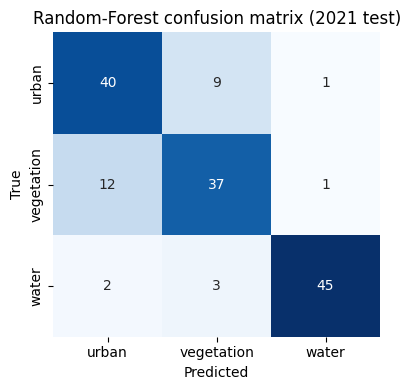

,precision,recall,f1-score,support
Metric,,,,
urban,0.74,0.80,0.77,50.00
vegetation,0.76,0.74,0.75,50.00
water,0.96,0.90,0.93,50.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.82,0.81,0.81,150.00
weighted avg,0.82,0.81,0.81,150.00


Cohen κ (RF, 2021) = 0.72


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Predict
y_pred = rf.predict(scaler.transform(X_ts))

# Confusion Matrix
cm = confusion_matrix(y_ts, y_pred, labels=enc.transform(enc.classes_))
fig_cm, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=enc.classes_, yticklabels=enc.classes_, ax=ax, cbar=False)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Random-Forest confusion matrix (2021 test)')
plt.tight_layout()
fig_cm.savefig(FIG/'rf_confusion_matrix.png', dpi=300)
plt.show()

# Classification Report Table
report = classification_report(
    y_ts, y_pred, target_names=enc.classes_, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T.rename_axis('Metric').round(2)
report_df.to_csv(ROOT/'data'/'rf_class_report_2021.csv')
display(report_df)

# Cohen’s Kappa
kappa_rf = cohen_kappa_score(y_ts, y_pred)
print(f'Cohen κ (RF, 2021) = {kappa_rf:.2f}')

## 5. Predict full rasters (2020-2024)


In [12]:
palette = {
    0: (0.70, 0.87, 0.54),
    1: (0.20, 0.63, 0.17),
    2: (0.12, 0.47, 0.71)
}


for yr in range(2020, 2025):
    with rasterio.open(RAW/f's2_wf_{yr}.tif') as src:
        arr   = src.read().astype('float32')
        prof  = src.profile
        flat  = arr.reshape(arr.shape[0], -1).T
        mask  = np.any(np.isnan(flat), axis=1)
        preds = np.full(flat.shape[0], 255, 'uint8')
        preds[~mask] = rf.predict(scaler.transform(flat[~mask]))
        label_img = preds.reshape(arr.shape[1:])
    # GeoTIFF
    prof.update(count=1, dtype='uint8', nodata=255, compress='deflate')
    out_tif = MAPS/f'rf_wf_{yr}.tif'
    with rasterio.open(out_tif, 'w', **prof) as dst: dst.write(label_img, 1)
    # PNG
    rgb = np.zeros(label_img.shape+(3,), 'float32')
    for k, col in palette.items(): rgb[label_img==k] = col
    plt.imsave(FIG/f'rf_wf_{yr}.png', rgb)
    print('Saved', yr)

Saved 2020
Saved 2021
Saved 2022
Saved 2023
Saved 2024


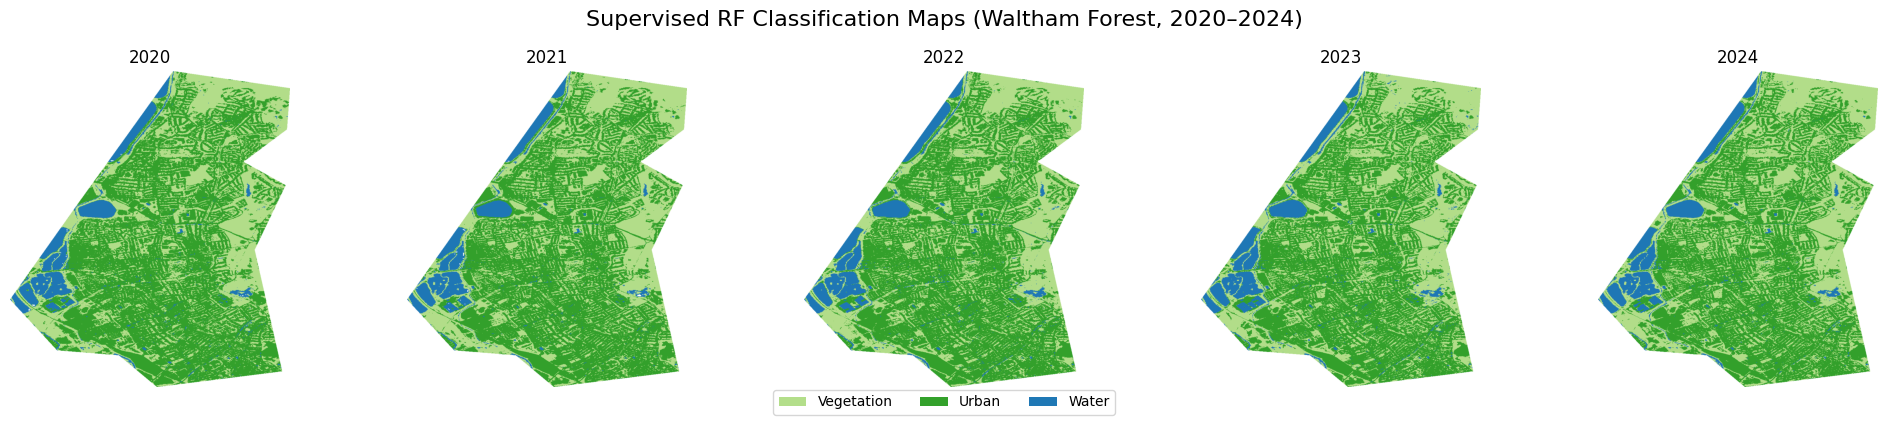

In [13]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.patches import Patch

# Setup
years = range(2020, 2025)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()

# RF colour palette and labels
palette = {
    0: (0.70, 0.87, 0.54),
    1: (0.20, 0.63, 0.17),
    2: (0.12, 0.47, 0.71)
}

labels = {
    0: "Vegetation",
    1: "Urban",
    2: "Water"
}

for i, yr in enumerate(years):
    with rasterio.open(MAPS / f'rf_wf_{yr}.tif') as src:
        label_img = src.read(1)

    rgb = np.ones(label_img.shape + (3,), dtype='float32')  # white background
    for k, col in palette.items():
        rgb[label_img == k] = col

    axes[i].imshow(rgb)
    axes[i].axis('off')
    axes[i].set_title(str(yr))

# Create legend
legend_elements = [Patch(facecolor=palette[cls], label=labels[cls]) for cls in palette]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Supervised RF Classification Maps (Waltham Forest, 2020–2024)", fontsize=16)
plt.tight_layout()
plt.savefig(FIG / "rf_classification_maps_panel.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Feature Importance and Model Interpretation


## 6.1 Feature Importance
Assess the contribution of each spectral band to the RF decision process using the built-in feature importance metric.

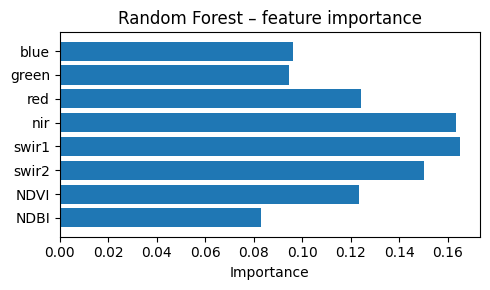

In [14]:
imp = rf.feature_importances_
band_names = ['blue','green','red','nir','swir1','swir2','NDVI','NDBI']

plt.figure(figsize=(5,3))
plt.barh(range(len(imp)), imp, tick_label=band_names)
plt.gca().invert_yaxis()
plt.xlabel('Importance'); plt.title('Random Forest – feature importance')
plt.tight_layout(); plt.savefig(FIG/'rf_feature_importance.png', dpi=250); plt.show()

## 7. K-Means vs Random-Forest   


### 7.1 Quantitative Comparison of Area Estimates (2020 vs 2024)
This section directly compares the estimated land-cover areas from both the supervised Random Forest model and the unsupervised K-means clusters. It highlights consistency in water mapping, and quantifies net urban expansion detected by RF.

In [15]:
import rasterio
import numpy as np
import pandas as pd

# Load RF maps
with rasterio.open(MAPS/'rf_wf_2020.tif') as src:
    rf_2020 = src.read(1)

with rasterio.open(MAPS/'rf_wf_2024.tif') as src:
    rf_2024 = src.read(1)

# Load K-means maps
with rasterio.open(ROOT/'maps'/'kmeans'/'kmeans_wf_2020.tif') as src:
    k_2020 = src.read(1)

with rasterio.open(ROOT/'maps'/'kmeans'/'kmeans_wf_2024.tif') as src:
    k_2024 = src.read(1)

# Class/cluster IDs
rf_urban_idx  = 0
rf_water_idx  = 2
k_water_id    = 3
urban_k_cluster_ids = [0, 2]

# RF Metrics
urban_rf_2020 = np.sum(rf_2020 == rf_urban_idx)
urban_rf_2024 = np.sum(rf_2024 == rf_urban_idx)
urban_rf_change = 100 * (urban_rf_2024 - urban_rf_2020) / urban_rf_2020

water_rf_2020 = np.sum(rf_2020 == rf_water_idx)
water_rf_2024 = np.sum(rf_2024 == rf_water_idx)
water_rf_agreement = 100 * abs(water_rf_2024 - water_rf_2020) / ((water_rf_2024 + water_rf_2020) / 2)

# K-means Metrics
urban_k_2020 = sum(np.sum(k_2020 == cid) for cid in urban_k_cluster_ids)
urban_k_2024 = sum(np.sum(k_2024 == cid) for cid in urban_k_cluster_ids)
urban_k_change = 100 * (urban_k_2024 - urban_k_2020) / urban_k_2020

water_k_2020 = np.sum(k_2020 == k_water_id)
water_k_2024 = np.sum(k_2024 == k_water_id)
water_k_agreement = 100 * abs(water_k_2024 - water_k_2020) / ((water_k_2024 + water_k_2020) / 2)

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': [
        'Water area (2020)',
        'Water area (2024)',
        'Water area agreement (±%)',
        'Urban area (2020)',
        'Urban area (2024)',
        'Net urban expansion (%)',
    ],
    'Random Forest': [
        water_rf_2020,
        water_rf_2024,
        round(water_rf_agreement, 2),
        urban_rf_2020,
        urban_rf_2024,
        round(urban_rf_change, 2),
    ],
    'K-means': [
        water_k_2020,
        water_k_2024,
        round(water_k_agreement, 2),
        urban_k_2020,
        urban_k_2024,
        round(urban_k_change, 2),
    ]
})

display(comparison_df)

,Metric,Random Forest,K-means
0,Water area (2020),43727.00,36993.00
1,Water area (2024),43792.00,37789.00
2,Water area agreement (±%),0.15,2.13
3,Urban area (2020),218886.00,375181.00
4,Urban area (2024),249677.00,345962.00
5,Net urban expansion (%),14.07,-7.79


###  7.2 Visual Change Maps (2020 → 2024)
This section highlights pixel-wise changes detected by each method between 2020 and 2024. We'll generate and save one binary change map per model showing:

- Where urban area expanded

- Where vegetation was lost



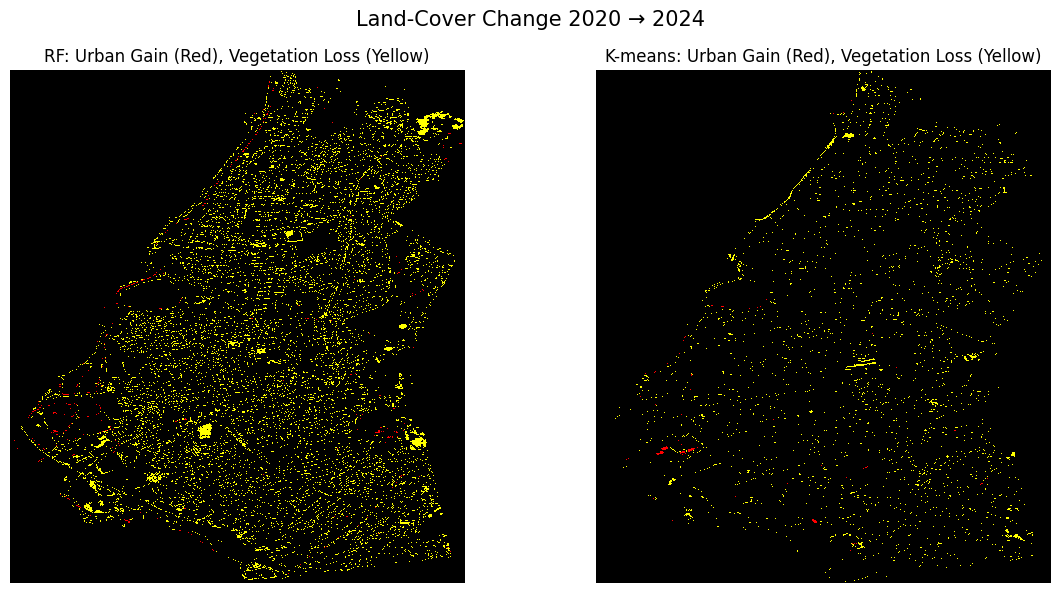

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap

# Load maps
rf_2020 = rasterio.open(MAPS/'rf_wf_2020.tif').read(1)
rf_2024 = rasterio.open(MAPS/'rf_wf_2024.tif').read(1)

k_2020 = rasterio.open(ROOT/'maps/kmeans/kmeans_wf_2020.tif').read(1)
k_2024 = rasterio.open(ROOT/'maps/kmeans/kmeans_wf_2024.tif').read(1)

# Class definitions
rf_urban = 0
rf_veg   = 1
kmeans_urban_ids = [0, 2]
kmeans_veg_id    = 1

# Change detection
# Random Forest
rf_change_map = np.zeros_like(rf_2020, dtype=np.uint8)
rf_change_map[(rf_2020 != rf_urban) & (rf_2024 == rf_urban)] = 1  # urban gain
rf_change_map[(rf_2020 == rf_veg) & (rf_2024 != rf_veg)] = 2      # vegetation loss

# K-means
k_change_map = np.zeros_like(k_2020, dtype=np.uint8)
k_change_map[(~np.isin(k_2020, kmeans_urban_ids)) & (np.isin(k_2024, kmeans_urban_ids))] = 1
k_change_map[(k_2020 == kmeans_veg_id) & (k_2024 != kmeans_veg_id)] = 2

# Colourmap (black = stable, red = urban gain, yellow = vegetation loss)
cmap = ListedColormap(['black', 'red', 'yellow'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rf_change_map, cmap=cmap, interpolation='nearest')
axes[0].set_title('RF: Urban Gain (Red), Vegetation Loss (Yellow)')
axes[0].axis('off')

axes[1].imshow(k_change_map, cmap=cmap, interpolation='nearest')
axes[1].set_title('K-means: Urban Gain (Red), Vegetation Loss (Yellow)')
axes[1].axis('off')

plt.suptitle("Land-Cover Change 2020 → 2024", fontsize=15)
plt.tight_layout()
plt.savefig(FIG/'rf_kmeans_change_maps.png', dpi=300)
plt.show()

### 7.3 Class Coverage (%) — RF vs K-Means (2024)
This section computes the proportion of each class in 2024 for both classification methods, normalised to percentage values. Useful for identifying biases in class allocation between the models.

In [17]:
import rasterio
import numpy as np
import pandas as pd

# Load 2024 maps
with rasterio.open(MAPS / 'rf_wf_2024.tif') as src:
    rf_2024 = src.read(1)
    rf_nodata = src.nodata or 255

with rasterio.open(ROOT / 'maps/kmeans/kmeans_wf_2024.tif') as src:
    km_2024 = src.read(1)
    km_nodata = src.nodata or 255

# Define class IDs
rf_labels = {0: 'Urban', 1: 'Vegetation', 2: 'Water'}
km_labels = {0: 'Urban', 1: 'Vegetation', 2: 'Industrial', 3: 'Water'}

# Create masks
rf_mask = rf_2024 != rf_nodata
km_mask = km_2024 != km_nodata

# RF class distribution (%)
rf_counts = {rf_labels[i]: np.sum(rf_2024[rf_mask] == i) for i in rf_labels}
rf_total = sum(rf_counts.values())
rf_percents = {k: round(100 * v / rf_total, 2) for k, v in rf_counts.items()}

# K-Means class distribution (%)
km_counts = {km_labels[i]: np.sum(km_2024[km_mask] == i) for i in km_labels}
km_total = sum(km_counts.values())
km_percents = {k: round(100 * v / km_total, 2) for k, v in km_counts.items()}

# Combine into DataFrame
df_cover = pd.DataFrame({
    'Class': sorted(set(rf_percents.keys()).union(km_percents.keys())),
    'Random Forest (%)': [rf_percents.get(cls, 0) for cls in sorted(set(rf_percents) | set(km_percents))],
    'K-Means (%)': [km_percents.get(cls, 0) for cls in sorted(set(rf_percents) | set(km_percents))],
})

# Display
df_cover = df_cover.set_index('Class')
display(df_cover)

,Random Forest (%),K-Means (%)
Class,,
Industrial,0.00,6.16
Urban,39.43,48.48
Vegetation,53.65,39.39
Water,6.92,5.97


# 8 Enviromental Impact summary


In [18]:
# End timer
end_time = time.time()
duration_sec = end_time - start_time
duration_hr = duration_sec / 3600

# Assumptions
CPU_POWER_W = 20
CARBON_INTENSITY = 0.233  # kg CO₂/kWh (UK grid)
ELECTRICITY_COST = 0.30   # £/kWh (UK average)

# Energy used (kWh) = power (kW) × time (h)
energy_kwh = (CPU_POWER_W / 1000) * duration_hr
co2_kg = energy_kwh * CARBON_INTENSITY
cost_gbp = energy_kwh * ELECTRICITY_COST

# Print results
print(f"Runtime: {duration_hr:.4f} hours")
print(f"Energy used: {energy_kwh:.6f} kWh")
print(f"CO₂ emitted: {co2_kg:.6f} kg CO₂eq")
print(f"Estimated cost: £{cost_gbp:.4f}")

Runtime: 0.0613 hours
Energy used: 0.001226 kWh
CO₂ emitted: 0.000286 kg CO₂eq
Estimated cost: £0.0004
